In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [2]:
def ff(x,omega):
    return omega 
    #If you just return ff=omega, this gives the usual Classifier free guidance, the same as the one 
    #called 'linear' in the calc_score function
    #return omega/(x**.75+1.e-6)
def calc_score(itau, dt,itfms,omega,q,sigma2):
    expt=np.exp(-dt*(itfms-itau))
    exp2t=expt**2
    gammat=(sigma2*exp2t+1-exp2t)
    linear=(expt/gammat)*(1+omega-omega*np.tanh(q*expt/gammat)) 
    # nonlinear=(expt/gammat)*(1+(1- np.tanh(q*expt/gammat))*ff((expt/gammat)*(1-np.tanh(q*expt)),omega))
    normdiff=(expt/gammat)*(1-np.tanh(q*expt/gammat))#Norm of S_full-S_class
    return linear,normdiff

def init_backward():
    return np.random.normal(0,1)
    
def calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2):
    # qinit: num, random initial value for q, 1D
    # nt: 800, num_steps?
    # dt: 0.01, time change
    # itfms: tau, final time - spec time 800-200=600
    # omega: CFG strength
    # sigma2: noise value
    
    qback=np.zeros(nt)
    time=np.zeros(nt)
    normd=np.zeros(nt)
    qback[0]=qinit # one dimensional initial value for q
    q=qback[0] # same as qinit
    time[0]=0
    for it in np.arange(nt-1):
        expt=np.exp(-dt*(itfms-it))
        exp2t=expt**2
        gammat=(sigma2*exp2t+1-exp2t)
        eta=np.random.normal(0,np.sqrt(2*dt))
        #rx=xback[it,:]
        sc,normdiff=calc_score(it, dt,itfms,omega,q,sigma2)
        q=q-dt*q*(2/gammat-1)+2*dt*sc+eta
        qback[it+1]=q
        time[it+1]=it*dt
        normd[it]=normdiff
    return time,qback,normd

In [3]:
#Here we run three single trajectories just to have a look
qinit=init_backward()
dt=.01
nt=800 #final time is nt*dt
dim=400
sigma2=1
# tspec=(1/2)*np.log(dim)
# ns=int(tspec/dt)
ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns
print('dim D=',dim,'iterations nt=',nt,'time step dt=',dt,'speciation ns=',ns)
omega=0
time,qtraj0,normdiff0=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2)
omega=0
time,qtraj1,normdiff1=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2)
omega=0
time,qtraj2,normdiff2=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2)

dim D= 400 iterations nt= 800 time step dt= 0.01 speciation ns= 200


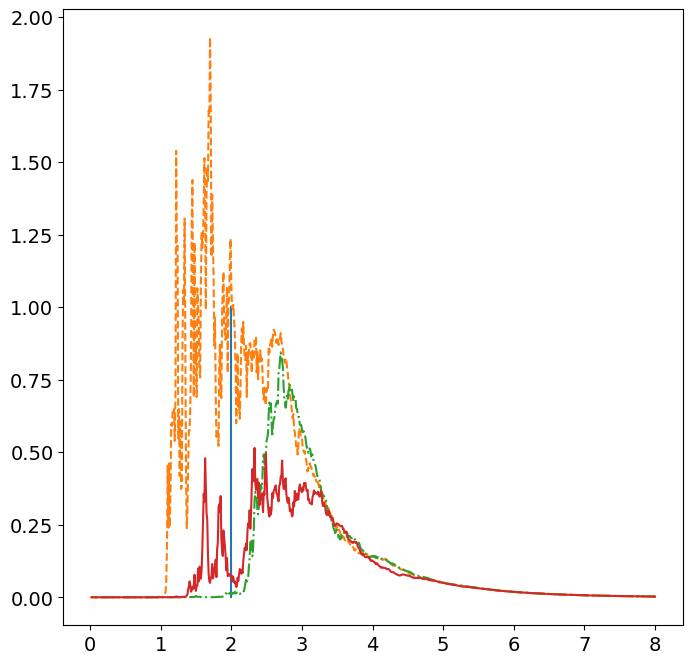

In [4]:
#plt.plot(nt*dt-time,qtraj0)
#plt.plot(nt*dt-time,qtraj1)
#plt.plot(nt*dt-time,qtraj4)
plt.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,1])
plt.plot(nt*dt-time,normdiff0,'--')
plt.plot(nt*dt-time,normdiff1,'-.')
plt.plot(nt*dt-time,normdiff2)
#plt.axis([0,6,0,.5])

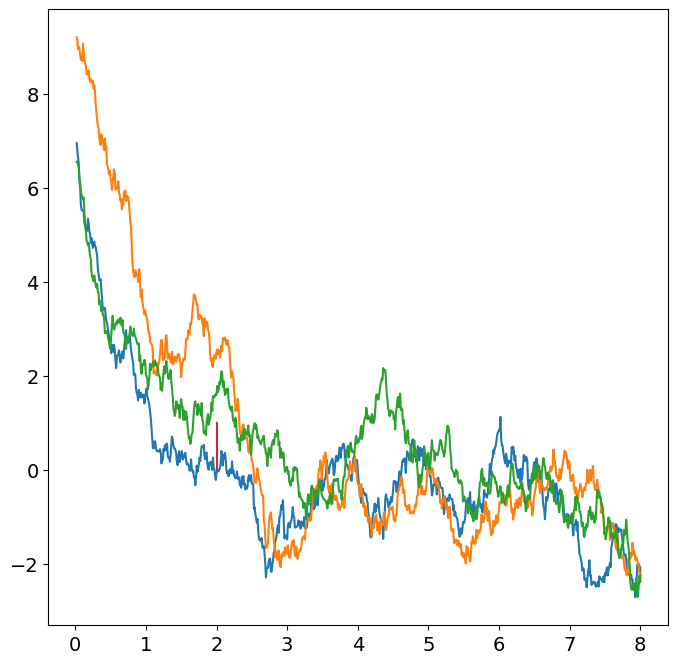

In [5]:
plt.plot(nt*dt-time,qtraj0)
plt.plot(nt*dt-time,qtraj1)
plt.plot(nt*dt-time,qtraj2)
plt.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,1])

#plt.axis([0,6,0,.5])

In [6]:
#Run nsample trajectories 
nsample=1000
dt=.01
nt=800 #final time is nt*dt
dim=100
sigma2=1
# tspec=(1/2)*np.log(dim)
# ns=int(tspec/dt)
ns=200 #speciation time is t_s=ns*dt=(1/2) log (d)
itfms=nt-ns
nomega=5
omegag=np.zeros(nomega)
qtraj=np.zeros((nomega,nsample,nt))
normstat=np.zeros((nomega,nsample,nt))
for ijk in np.arange(nsample):
    qinit=init_backward()
    for iomega in np.arange(nomega):
        omega=4*iomega
        omegag[iomega]=omega
        time,qtraj[iomega,ijk,:],normstat[iomega,ijk,:]=calc_traj_back_exact(qinit,nt,dt,itfms,omega,sigma2)

omega= 0.0
omega= 4.0
omega= 8.0
omega= 12.0
omega= 16.0


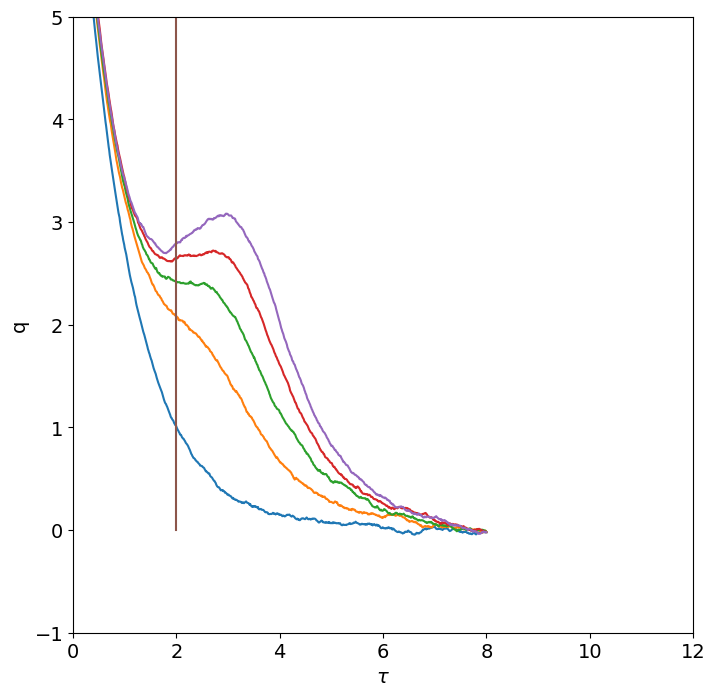

In [7]:
for iomega in np.arange(nomega):
    print('omega=',omegag[iomega])
    qav=np.mean(qtraj,axis=1)
    plt.plot(nt*dt-time,qav[iomega,:])
plt.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,5])
plt.xlabel(r'$\tau$')
plt.ylabel('q')
#plt.text(7,8,'$\omega=0$ to $16$')
plt.axis([0,12,-1,5])
#plt.savefig('free-guidance-gaussian-mixture-q-backward_v3.pdf')
plt.show()

omega= 0.0
omega= 16.0


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 array([0.        , 0.21052632, 0.42105263, 0.63157895, 0.84210526,
        1.05263158, 1.26315789, 1.47368421, 1.68421053, 1.89473684,
        2.10526316, 2.31578947, 2.52631579, 2.73684211, 2.94736842,
        3.15789474, 3.36842105, 3.57894737, 3.78947368, 4.        ]),
 <BarContainer object of 19 artists>)

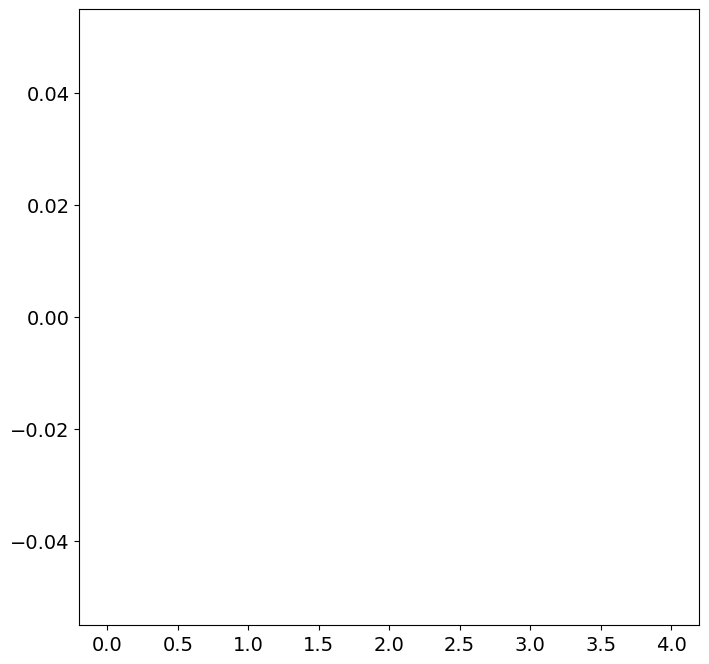

In [8]:
qav0=qtraj[:,:,nt-1]
binh=np.linspace(0,4,20)
iomega=0
print('omega=',omegag[iomega])
finalq=qav0[iomega,:]
plt.hist(finalq,binh,alpha=.3)
iomega=nomega-1
print('omega=',omegag[iomega])
finalq=qav0[iomega,:]
plt.hist(finalq,binh,alpha=.3)
#for iomega in np.arange(nomega):
#    print('omega=',omegag[iomega])
#    finalq=qav0[iomega,:]
#    plt.hist(finalq,binh)

omega= 0.0
omega= 4.0
omega= 8.0
omega= 12.0
omega= 16.0


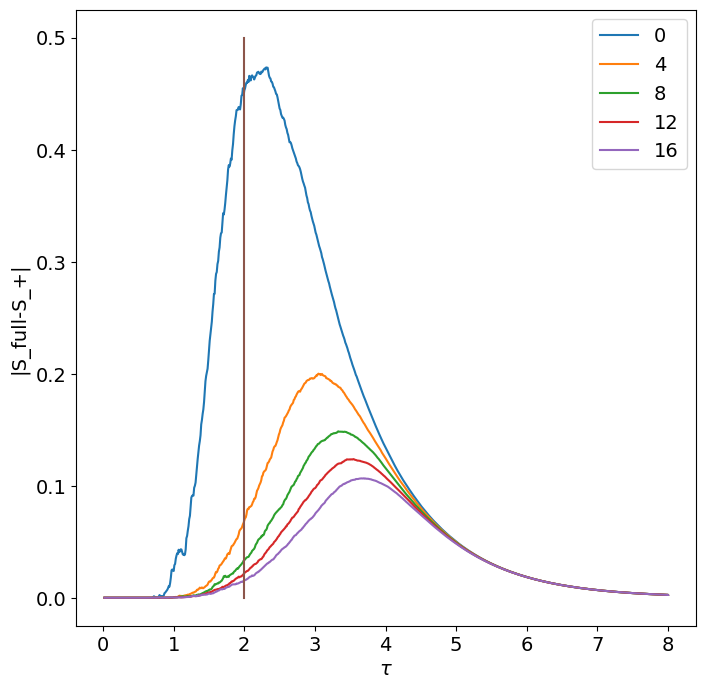

In [11]:
for iomega in np.arange(nomega):
    print('omega=',omegag[iomega])
    normav=np.mean(normstat,axis=1)
    plt.plot(nt*dt-time,normav[iomega,:], label=iomega*4)
plt.plot([nt*dt-dt*itfms,nt*dt-dt*itfms],[0,.5])
plt.xlabel(r'$\tau$')
plt.ylabel('|S_full-S_+|')
plt.legend()
#plt.text(7,8,'$\omega=0$ to $16$')
#plt.axis([0,12,-1,10])
#plt.savefig('free-guidance-gaussian-mixture-q-backward_v3.pdf')
plt.show()